Thinking of APR. Are we doing the dual optimization with the classification model + the pertubation added?

1. Run BPR and retrieve the model parameters + predict with parameters
2. Create input output for adversary and train + save adversary
3. tune data with the discussed methodology

In [1]:
#import relevant library

import math
import os
import random
import pickle
import argparse
from collections import deque
import time
import utility
import tqdm
import copy
from operator import itemgetter
from datetime import timedelta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
# from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
## time the process
def get_time_dif(start_time):
    """get the running time"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


## set up the u,i,j triplet for BPR framework
class GetTriplePair(IterableDataset):
    # for ml-1m we load in 3760 item 6040 user and 994169 train pair
    def __init__(self, item_size, user_list, pair, shuffle, num_epochs):
        self.item_size = item_size
        self.user_list = user_list
        self.pair = pair
        self.shuffle = shuffle
        self.num_epochs = num_epochs

    def __iter__(self):
        self.example_size = self.num_epochs * len(self.pair)
        self.example_index_queue = deque([])
        self.seed = 0
        self.start_list_index = None
        self.num_workers = 1
        self.index = 0
        return self

    def __next__(self):
        if self.index >= self.example_size:
            raise StopIteration
        # If `example_index_queue` is used up, replenish this list.
        while len(self.example_index_queue) == 0:
            index_list = list(range(len(self.pair)))
            if self.shuffle:
                random.Random(self.seed).shuffle(index_list)
                self.seed += 1
            if self.start_list_index is not None:
                index_list = index_list[self.start_list_index::self.num_workers]

                # Calculate next start index
                self.start_list_index = (self.start_list_index + (self.num_workers - (len(self.pair) % self.num_workers))) % self.num_workers
            self.example_index_queue.extend(index_list)
        result = self._example(self.example_index_queue.popleft())
        self.index += self.num_workers
        return result

    def _example(self, idx):
        # in a train pair, format = (u,i), j = a random item which does not exist in user u's list of items
        u = self.pair[idx][0]
        i = self.pair[idx][1]
        j = np.random.randint(self.item_size)
        while j in self.user_list[u]:
            j = np.random.randint(self.item_size)
        return u, i, j

## chunk to define matrix factorization part
class MF(nn.Module):
    def __init__(self, user_size, item_size, dim, reg, reg_adv, eps):
        super().__init__()
        ##init the embedding for U and I
        self.W = nn.Parameter(torch.empty(user_size, dim))  # User embedding
        self.H = nn.Parameter(torch.empty(item_size, dim))  # Item embedding
        nn.init.xavier_normal_(self.W.data)
        nn.init.xavier_normal_(self.H.data)
        self.reg = reg
        self.user_size = user_size
        self.item_size = item_size
        self.dim = dim
        self.reg_adv = reg_adv
        self.eps = eps
        self.update_u = None
        self.update_i = None
        self.update_j = None

## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.

        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
        u = self.W[u, :]
        i = self.H[i, :]
        j = self.H[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
        u.retain_grad()
        u_clone = u.data.clone()
        i.retain_grad()
        i_clone = i.data.clone()
        j.retain_grad()
        j_clone = j.data.clone()

        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(u, i).sum(dim=1)
        x_uj = torch.mul(u, j).sum(dim=1)


        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
        log_prob = F.logsigmoid(x_uij).sum()
        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (u.norm(dim=1).pow(2).sum() + i.norm(dim=1).pow(2).sum() + j.norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss = -log_prob + regularization

        loss.backward()
        return loss
        # add adv training after a certain number of epochs, here is the part which we add hypernet module
        if epoch not in range(args.epochs, args.adv_epoch + args.epochs):
            """Normal training"""
            loss.backward()
            return loss

        else:
            """Adversarial training:
                    1.Backward to get grads
                    2.Construct adversarial perturbation
                    3.Add adversarial perturbation to embeddings
                    4.Calculate APR loss
            """
            # Backward to get grads
            # this would be the part we change in defining delta, delta = HPN (phi)

            # should we calculate based on gradient of the adv_loss instead of the loss function?, originally, computed based on loss function
            loss.backward(retain_graph=True) ## need to retain graph here so as to we can backprop the adv_loss
            ##recheck this
            grad_u = u.grad
            grad_i = i.grad
            grad_j = j.grad

            # Construct adversarial perturbation based on gradient of loss function, and normalize it with epsilon * norm
            if grad_u is not None:
                delta_u = nn.functional.normalize(grad_u, p=2, dim=1, eps=self.eps)
            else:
                delta_u = torch.rand(u.size())
            if grad_i is not None:
                delta_i = nn.functional.normalize(grad_i, p=2, dim=1, eps=self.eps)
            else:
                delta_i = torch.rand(i.size())
            if grad_j is not None:
                delta_j = nn.functional.normalize(grad_j, p=2, dim=1, eps=self.eps)
            else:
                delta_j = torch.rand(j.size())

            # Add adversarial perturbation to embeddings, now we have q+delta, p+delta
            x_ui_adv = torch.mul(u + delta_u, i + delta_i).sum(dim=1)
            x_uj_adv = torch.mul(u + delta_u, j + delta_j).sum(dim=1)

            # find difference between pos and neg item, then clip value
            x_uij_adv = torch.clamp(x_ui_adv - x_uj_adv,min=-80.0,max=1e8)

            # Calculate APR loss with logsigmoid
            log_prob = F.logsigmoid(x_uij_adv).sum()
            adv_loss = self.reg_adv *(-log_prob) + loss # this is adversarial loss (equation 4 in paper)
            adv_loss.backward()

            return adv_loss


In [95]:
def evaluate_k(user_emb, item_emb, train_user_list, test_user_list, klist, batch=512):
    """Compute HR and NDCG at k.

    Args:
        user_emb (torch.Tensor): embedding for user [user_num, dim]
        item_emb (torch.Tensor): embedding for item [item_num, dim]
        train_user_list (list(set)):
        test_user_list (list(set)):
        k (list(int)):
    Returns:
        (torch.Tensor, torch.Tensor) HR and NDCG at k
    """

    # Calculate max k value
    max_k = max(klist)
    result = None

    # no iteration = user_num / batch size (which is 512)
    for i in range(0, user_emb.shape[0], batch):

        # Construct mask for each batch

        #new_ones returns a Tensor of size size filled with 1

        # size of the mask vector = (min of batch or user embed) * item+embed
        mask = user_emb.new_ones([min([batch, user_emb.shape[0]-i]), item_emb.shape[0]])
        for j in range(batch):
            if i+j >= user_emb.shape[0]:
                break
            mask[j].scatter_(dim=0, index=torch.tensor(list(train_user_list[i + j])), value=torch.tensor(0.0))

        # Get current result
        cur_result = torch.mm(user_emb[i:i+min(batch, user_emb.shape[0]-i), :], item_emb.t())
        cur_result = torch.sigmoid(cur_result)
        assert not torch.any(torch.isnan(cur_result))

        # Make zero for already observed item
        cur_result = torch.mul(mask, cur_result)
        _, cur_result = torch.topk(cur_result, k=max_k, dim=1)
        result = cur_result if result is None else torch.cat((result, cur_result), dim=0)


    ## basically this chunk collects the results
    result = result.cpu()

    # Sort indice and get HR_NDCG_topk
    HRs, NDCGs = [], []
    for k in klist:
        ndcg, hr = 0, 0
        #for all user
        for i in range(user_emb.shape[0]):
            #set helps to identify unique members in a list
            test = set(test_user_list[i])
            #top k item from prediction list
            pred = set(result[i, :k].numpy().tolist())
            #if topk lies on both test and pred list
            val = len(test & pred)
            #hit ratio = %item hit
            hr += val / max([len(test), 1])
            #convert pred back to list
            pred = list(pred)
            if test_user_list[i] == []:
                continue
            else:
                x = int(test_user_list[i][0])
                ## check if x is in the prediction where x = 1st member of user list
                if pred.count(x) != 0:
                    position = pred.index(x)
                    ndcg += math.log(2) / math.log(position + 2) if position < k else 0
                else:
                    ndcg += 0                
#                 for x in test_user_list[i]:
#                     x = int(x)
#                     ## check if x is in the prediction where x = 1st member of user list
#                     if pred.count(x) != 0:
#                         position = pred.index(x)
#                         ndcg += math.log(2) / math.log(position + 2) if position < k else 0
#                     else:
#                         ndcg += 0
        NDCGs.append(ndcg / user_emb.shape[0])
        HRs.append(hr / user_emb.shape[0])
        NDCGs.append(ndcg / user_emb.shape[0])
    return HRs, NDCGs


In [96]:
with open('preprocessed/ml-1m-2.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [97]:
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 1000)

# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
model = MF(user_size, item_size, 64, 0, 1, 0.5)

In [100]:
optimizer = optim.Adam(model.parameters(), lr=0.00025)

# Training
start_time = time.time()
eval_best_loss = float('inf')

##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
# result_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(1000):
        loss = model(u, i, j, epoch)

        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(model.W.detach(),
                                        model.H.detach(),
                                        train_user_list,
                                        test_user_list,
                                        klist=[50, 100])
        if epoch % 20 == (20- 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/bpr_manual'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/bpr_manual')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break


time 0:00:01
BPR-MF Epoch [20/1000]
loss: 354.9578
HR@50: 0.0356, HR@100: 0.0685, NDCG@50: 0.0094, NDCG@100: 0.0094
BPR-MF Epoch [40/1000]
loss: 354.9597
HR@50: 0.0375, HR@100: 0.0716, NDCG@50: 0.0096, NDCG@100: 0.0096
BPR-MF Epoch [60/1000]
loss: 355.0354
HR@50: 0.0376, HR@100: 0.0721, NDCG@50: 0.0103, NDCG@100: 0.0103
BPR-MF Epoch [80/1000]
loss: 354.8369
HR@50: 0.0374, HR@100: 0.0748, NDCG@50: 0.0105, NDCG@100: 0.0105
BPR-MF Epoch [100/1000]
loss: 354.6431
HR@50: 0.0403, HR@100: 0.0754, NDCG@50: 0.0120, NDCG@100: 0.0120
BPR-MF Epoch [120/1000]
loss: 354.6406
HR@50: 0.0422, HR@100: 0.0810, NDCG@50: 0.0117, NDCG@100: 0.0117
BPR-MF Epoch [140/1000]
loss: 354.3599
HR@50: 0.0459, HR@100: 0.0840, NDCG@50: 0.0131, NDCG@100: 0.0131
BPR-MF Epoch [160/1000]
loss: 354.1075
HR@50: 0.0502, HR@100: 0.0941, NDCG@50: 0.0140, NDCG@100: 0.0140
BPR-MF Epoch [180/1000]
loss: 353.4531
HR@50: 0.0585, HR@100: 0.1090, NDCG@50: 0.0167, NDCG@100: 0.0167
BPR-MF Epoch [200/1000]
loss: 352.7574
HR@50: 0.0710, H

for ml-1m-6 data set with continue , epoch 1000 has
loss: 160.6638
HR@50: 0.3218, HR@100: 0.4558, NDCG@50: 0.0939, NDCG@100: 0.0939

for ml-1m-6 data set with continue + for loop for X in test user set , epoch 1000 has
loss: 196.0934
HR@50: 0.3266, HR@100: 0.4649, NDCG@50: 0.7004, NDCG@100: 0.7004


ml-1m normal dataset
loss: 150.8645
HR@50: 0.1437, HR@100: 0.2245, NDCG@50: 0.0365, NDCG@100: 0.0365

test ml-1m normal dataset with for loop for X in test user set
loss: 181.7949
HR@50: 0.1480, HR@100: 0.2252, NDCG@50: 0.0373, NDCG@100: 0.0373

In [ ]:
fig_HR = plt.figure(edgecolor='blue')
ax1 = fig_HR.add_subplot(111)
plt.ylabel('HR@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(HR_history)), HR_history, c=np.array([255, 71, 90]) / 255.)
plt.show()
fig_P = plt.figure(edgecolor='blue')
ax1 = fig_P.add_subplot(111)
plt.ylabel('NDCG@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(NDCG_history)), NDCG_history, c=np.array([255, 71, 90]) / 255.)
plt.show()

Running a saving output of BPR model

Next up = train adversary based on fixed parameters of BPR

In [3]:
train_df = pd.read_pickle(r'ml1m-6/training_df.pkl')
vali_df = pd.read_pickle(r'ml1m-6/valiing_df.pkl')
key_genre = pd.read_pickle(r'ml1m-6/key_genre.pkl')  
item_idd_genre_list = pd.read_pickle(r'ml1m-6/item_idd_genre_list.pkl')   
genre_item_vector = pd.read_pickle(r'ml1m-6/genre_item_vector.pkl')    
genre_count = pd.read_pickle(r'ml1m-6/genre_count.pkl')      
user_genre_count = pd.read_pickle(r'ml1m-6/user_genre_count.pkl') 

num_item = len(train_df['item_id'].unique())
num_user = len(train_df['user_id'].unique())
num_genre = len(key_genre)

In [4]:
genre_count

{'Sci-Fi': 271,
 'Horror': 330,
 'Crime': 193,
 'Romance': 447,
 "Children's": 248,
 'Adventure': 276}

In [5]:
item_genre_list = []
for u in range(num_item):
    gl = item_idd_genre_list[u]
    tmp = []
    for g in gl:
        if g in key_genre:
            tmp.append(g)
    item_genre_list.append(tmp)

item_genre = np.zeros((num_item, num_genre))
for i in range(num_item):
    gl = item_genre_list[i]
    for k in range(num_genre):
        if key_genre[k] in gl:
            item_genre[i, k] = 1.0

genre_count_mean_reciprocal = []

##there are six key_genre --> in the training dataset, count the number of movies for each genre
#genre_count = dictionary with number of movies for each keygrenre
for k in key_genre:
    genre_count_mean_reciprocal.append(1.0 / genre_count[k])
genre_count_mean_reciprocal = (np.array(genre_count_mean_reciprocal)).reshape((num_genre, 1))
genre_error_weight = np.dot(item_genre, genre_count_mean_reciprocal)

In [6]:
genre_count_mean_reciprocal

array([[0.00369004],
       [0.0030303 ],
       [0.00518135],
       [0.00362319],
       [0.00403226],
       [0.00223714]])

In [7]:
item_genre = torch.from_numpy(item_genre).type(torch.float)
item_genre.size()

torch.Size([1481, 6])

In [8]:
#load the results of BPR
model1 = (torch.load('output/bpr_manual'))
list(model1.items())[0][1].size(),list(model1.items())[1][1].size()




(torch.Size([6036, 64]), torch.Size([1481, 64]))

In [9]:
Rec = np.matmul(list(model1.items())[0][1], list(model1.items())[1][1].T)
Rec.size()
# Rec[1,:].size()


torch.Size([6036, 1481])

In [11]:
top4=15

In [30]:
record = []
for u in range(num_user):  # iterate each user
    #extract item that user actually match during testing, extract the prediction
    u_test = (vali_df.loc[vali_df['user_id'] == u, 'item_id']).tolist()
    u_pred = Rec[u, :]


    #get top 15 items
    top15_item_idx_no_train = np.argpartition(u_pred, -1 * top4)[-1 * top4:]
    top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
    top15 = sorted(top15, key=itemgetter(1), reverse=True)
    record.append(top15[1] == [])

/var/folders/mn/417m__h56216y1lcqcrf32qc0000gn/T/ipykernel_46997/376424729.py:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/var/folders/mn/417m__h56216y1lcqcrf32qc0000gn/T/ipykernel_46997/376424729.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_i

In [32]:
top15

[tensor([271, 319,  56, 106, 135,  68,  33, 208,  10,  13,  23,  66,   3, 108,
          92]),
 tensor([5.1060, 5.3269, 5.3864, 5.3278, 5.3401, 5.4065, 5.3273, 5.4410, 5.7310,
         5.5672, 5.7534, 5.4423, 5.5508, 5.4972, 5.6141])]

In [10]:
import utility
utility.ranking_analysis(Rec, vali_df, train_df, key_genre,
                                                      item_genre_list, user_genre_count)

/Users/vuhoang/Documents/code_base/APR-PyTorch/utility.py:292: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/Users/vuhoang/Documents/code_base/APR-PyTorch/utility.py:292: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_

IndexError: list index out of range

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Rec.T, 
                                                    item_genre, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(1184, 297, 1184, 297)

In [161]:
#adv, linear-relu, linear-sigmoid last layer, numlayer = 4, 512,256,128,64 hidden units 

adversary = nn.Sequential(
    nn.Linear(list(model1.items())[0][1].size()[0], 100),
#     nn.ReLU(),
    nn.Linear(100, 50),
#     nn.ReLU(),
    nn.Linear(50, 25),
#     nn.ReLU(),
    nn.Linear(25, 6),
    nn.Sigmoid()
)

In [191]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.Adam(params=adversary.parameters(), 
                            lr=0.0025)

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / (y_true.size()[0]*y_true.size()[1])) * 100 
    return acc

In [171]:
torch.manual_seed(18)

# Set the number of epochs
epochs = 300

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    adversary.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = adversary(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round((y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    adversary.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = adversary(X_test).squeeze() 
        test_pred = torch.round((test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69304, Accuracy: 80.01% | Test loss: 0.69316, Test acc: 80.81%
Epoch: 10 | Loss: 0.69301, Accuracy: 80.01% | Test loss: 0.69316, Test acc: 80.81%
Epoch: 20 | Loss: 0.69299, Accuracy: 80.03% | Test loss: 0.69317, Test acc: 80.81%
Epoch: 30 | Loss: 0.69295, Accuracy: 80.03% | Test loss: 0.69319, Test acc: 80.81%
Epoch: 40 | Loss: 0.69289, Accuracy: 80.04% | Test loss: 0.69324, Test acc: 80.81%
Epoch: 50 | Loss: 0.69279, Accuracy: 80.07% | Test loss: 0.69345, Test acc: 80.81%
Epoch: 60 | Loss: 0.69260, Accuracy: 80.17% | Test loss: 0.69368, Test acc: 80.81%
Epoch: 70 | Loss: 0.69238, Accuracy: 80.22% | Test loss: 0.69404, Test acc: 80.64%
Epoch: 80 | Loss: 0.69208, Accuracy: 80.29% | Test loss: 0.69465, Test acc: 80.70%
Epoch: 90 | Loss: 0.69170, Accuracy: 80.41% | Test loss: 0.69604, Test acc: 80.47%
Epoch: 100 | Loss: 0.69139, Accuracy: 80.50% | Test loss: 0.69600, Test acc: 80.36%
Epoch: 110 | Loss: 0.69110, Accuracy: 80.64% | Test loss: 0.69567, Test acc: 80.47%
Epo

In [193]:
# prepare model and training parameters
n_epochs = 100
batch_size = 100
batches_per_epoch = len(X_train) // batch_size
 
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    adversary.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = adversary(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = accuracy_fn(y_true=y_batch, 
                      y_pred=y_pred)
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    adversary.eval()
    y_pred = adversary(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = accuracy_fn(y_true=y_test, 
                      y_pred=y_pred)
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(adversary.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc:.1f}%")
 


Epoch 0: 100%|█████████████| 11/11 [00:00<00:00, 79.34batch/s, acc=74.7, loss=0.691]


Epoch 0 validation: Cross-entropy=0.69, Accuracy=74.5%


Epoch 1: 100%|█████████████| 11/11 [00:00<00:00, 79.80batch/s, acc=74.2, loss=0.691]


Epoch 1 validation: Cross-entropy=0.69, Accuracy=74.5%


Epoch 2: 100%|█████████████| 11/11 [00:00<00:00, 80.74batch/s, acc=73.8, loss=0.691]


Epoch 2 validation: Cross-entropy=0.70, Accuracy=73.5%


Epoch 3: 100%|█████████████| 11/11 [00:00<00:00, 82.91batch/s, acc=73.8, loss=0.691]


Epoch 3 validation: Cross-entropy=0.70, Accuracy=73.4%


Epoch 4: 100%|█████████████| 11/11 [00:00<00:00, 84.60batch/s, acc=74.5, loss=0.691]


Epoch 4 validation: Cross-entropy=0.69, Accuracy=75.4%


Epoch 5: 100%|█████████████| 11/11 [00:00<00:00, 90.47batch/s, acc=73.7, loss=0.691]


Epoch 5 validation: Cross-entropy=0.70, Accuracy=73.5%


Epoch 6: 100%|█████████████| 11/11 [00:00<00:00, 76.63batch/s, acc=71.3, loss=0.692]


Epoch 6 validation: Cross-entropy=0.70, Accuracy=70.4%


Epoch 7: 100%|█████████████| 11/11 [00:00<00:00, 75.59batch/s, acc=70.8, loss=0.691]


Epoch 7 validation: Cross-entropy=0.70, Accuracy=70.4%


Epoch 8: 100%|█████████████| 11/11 [00:00<00:00, 85.38batch/s, acc=72.5, loss=0.689]


Epoch 8 validation: Cross-entropy=0.70, Accuracy=74.2%


Epoch 9: 100%|██████████████| 11/11 [00:00<00:00, 80.09batch/s, acc=73.2, loss=0.69]


Epoch 9 validation: Cross-entropy=0.69, Accuracy=74.9%


Epoch 10: 100%|██████████████| 11/11 [00:00<00:00, 81.03batch/s, acc=72, loss=0.691]


Epoch 10 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 11: 100%|████████████| 11/11 [00:00<00:00, 88.04batch/s, acc=70.2, loss=0.692]


Epoch 11 validation: Cross-entropy=0.70, Accuracy=73.2%


Epoch 12: 100%|██████████████| 11/11 [00:00<00:00, 78.86batch/s, acc=70, loss=0.693]


Epoch 12 validation: Cross-entropy=0.70, Accuracy=72.3%


Epoch 13: 100%|████████████| 11/11 [00:00<00:00, 79.88batch/s, acc=71.8, loss=0.691]


Epoch 13 validation: Cross-entropy=0.70, Accuracy=73.6%


Epoch 14: 100%|████████████| 11/11 [00:00<00:00, 96.39batch/s, acc=72.8, loss=0.691]


Epoch 14 validation: Cross-entropy=0.70, Accuracy=74.5%


Epoch 15: 100%|████████████| 11/11 [00:00<00:00, 97.58batch/s, acc=72.5, loss=0.692]


Epoch 15 validation: Cross-entropy=0.70, Accuracy=75.2%


Epoch 16: 100%|████████████| 11/11 [00:00<00:00, 89.62batch/s, acc=73.2, loss=0.692]


Epoch 16 validation: Cross-entropy=0.70, Accuracy=75.9%


Epoch 17: 100%|████████████| 11/11 [00:00<00:00, 79.71batch/s, acc=75.3, loss=0.691]


Epoch 17 validation: Cross-entropy=0.69, Accuracy=77.3%


Epoch 18: 100%|██████████████| 11/11 [00:00<00:00, 93.20batch/s, acc=75, loss=0.692]


Epoch 18 validation: Cross-entropy=0.69, Accuracy=77.2%


Epoch 19: 100%|█████████████| 11/11 [00:00<00:00, 93.58batch/s, acc=74.5, loss=0.69]


Epoch 19 validation: Cross-entropy=0.70, Accuracy=75.8%


Epoch 20: 100%|█████████████| 11/11 [00:00<00:00, 81.19batch/s, acc=73.8, loss=0.69]


Epoch 20 validation: Cross-entropy=0.70, Accuracy=76.3%


Epoch 21: 100%|██████████████| 11/11 [00:00<00:00, 88.85batch/s, acc=73, loss=0.691]


Epoch 21 validation: Cross-entropy=0.70, Accuracy=76.2%


Epoch 22: 100%|████████████| 11/11 [00:00<00:00, 96.35batch/s, acc=73.5, loss=0.691]


Epoch 22 validation: Cross-entropy=0.70, Accuracy=75.6%


Epoch 23: 100%|██████████████| 11/11 [00:00<00:00, 98.44batch/s, acc=73, loss=0.691]


Epoch 23 validation: Cross-entropy=0.70, Accuracy=75.1%


Epoch 24: 100%|██████████████| 11/11 [00:00<00:00, 93.56batch/s, acc=73, loss=0.691]


Epoch 24 validation: Cross-entropy=0.70, Accuracy=74.9%


Epoch 25: 100%|█████████████| 11/11 [00:00<00:00, 91.79batch/s, acc=72.5, loss=0.69]


Epoch 25 validation: Cross-entropy=0.70, Accuracy=74.8%


Epoch 26: 100%|█████████████| 11/11 [00:00<00:00, 89.84batch/s, acc=72.2, loss=0.69]


Epoch 26 validation: Cross-entropy=0.70, Accuracy=74.7%


Epoch 27: 100%|█████████████| 11/11 [00:00<00:00, 82.19batch/s, acc=72.2, loss=0.69]


Epoch 27 validation: Cross-entropy=0.70, Accuracy=74.6%


Epoch 28: 100%|█████████████| 11/11 [00:00<00:00, 88.25batch/s, acc=71.8, loss=0.69]


Epoch 28 validation: Cross-entropy=0.70, Accuracy=75.2%


Epoch 29: 100%|██████████████| 11/11 [00:00<00:00, 103.78batch/s, acc=72, loss=0.69]


Epoch 29 validation: Cross-entropy=0.70, Accuracy=75.9%


Epoch 30: 100%|███████████████| 11/11 [00:00<00:00, 99.02batch/s, acc=71, loss=0.69]


Epoch 30 validation: Cross-entropy=0.70, Accuracy=75.4%


Epoch 31: 100%|█████████████| 11/11 [00:00<00:00, 98.32batch/s, acc=71.2, loss=0.69]


Epoch 31 validation: Cross-entropy=0.70, Accuracy=75.3%


Epoch 32: 100%|████████████| 11/11 [00:00<00:00, 96.17batch/s, acc=72.8, loss=0.691]


Epoch 32 validation: Cross-entropy=0.70, Accuracy=75.9%


Epoch 33: 100%|██████████████| 11/11 [00:00<00:00, 86.79batch/s, acc=70, loss=0.691]


Epoch 33 validation: Cross-entropy=0.70, Accuracy=74.2%


Epoch 34: 100%|████████████| 11/11 [00:00<00:00, 85.25batch/s, acc=70.3, loss=0.689]


Epoch 34 validation: Cross-entropy=0.70, Accuracy=73.3%


Epoch 35: 100%|█████████████| 11/11 [00:00<00:00, 96.00batch/s, acc=70.7, loss=0.69]


Epoch 35 validation: Cross-entropy=0.70, Accuracy=73.3%


Epoch 36: 100%|████████████| 11/11 [00:00<00:00, 92.34batch/s, acc=73.3, loss=0.691]


Epoch 36 validation: Cross-entropy=0.70, Accuracy=75.1%


Epoch 37: 100%|████████████| 11/11 [00:00<00:00, 83.35batch/s, acc=72.7, loss=0.688]


Epoch 37 validation: Cross-entropy=0.70, Accuracy=74.1%


Epoch 38: 100%|████████████| 11/11 [00:00<00:00, 86.20batch/s, acc=73.2, loss=0.687]


Epoch 38 validation: Cross-entropy=0.70, Accuracy=74.0%


Epoch 39: 100%|████████████| 11/11 [00:00<00:00, 81.07batch/s, acc=74.7, loss=0.687]


Epoch 39 validation: Cross-entropy=0.70, Accuracy=74.4%


Epoch 40: 100%|████████████| 11/11 [00:00<00:00, 97.64batch/s, acc=75.3, loss=0.688]


Epoch 40 validation: Cross-entropy=0.70, Accuracy=75.8%


Epoch 41: 100%|████████████| 11/11 [00:00<00:00, 89.52batch/s, acc=74.2, loss=0.689]


Epoch 41 validation: Cross-entropy=0.70, Accuracy=75.0%


Epoch 42: 100%|█████████████| 11/11 [00:00<00:00, 93.07batch/s, acc=72.7, loss=0.69]


Epoch 42 validation: Cross-entropy=0.70, Accuracy=73.5%


Epoch 43: 100%|████████████| 11/11 [00:00<00:00, 88.61batch/s, acc=74.5, loss=0.689]


Epoch 43 validation: Cross-entropy=0.70, Accuracy=74.5%


Epoch 44: 100%|███████████████| 11/11 [00:00<00:00, 95.30batch/s, acc=76, loss=0.69]


Epoch 44 validation: Cross-entropy=0.69, Accuracy=77.2%


Epoch 45: 100%|███████████| 11/11 [00:00<00:00, 106.21batch/s, acc=75.2, loss=0.689]


Epoch 45 validation: Cross-entropy=0.70, Accuracy=75.5%


Epoch 46: 100%|████████████| 11/11 [00:00<00:00, 90.56batch/s, acc=72.2, loss=0.689]


Epoch 46 validation: Cross-entropy=0.70, Accuracy=73.2%


Epoch 47: 100%|████████████| 11/11 [00:00<00:00, 81.05batch/s, acc=73.2, loss=0.689]


Epoch 47 validation: Cross-entropy=0.70, Accuracy=74.4%


Epoch 48: 100%|███████████████| 11/11 [00:00<00:00, 92.41batch/s, acc=75, loss=0.69]


Epoch 48 validation: Cross-entropy=0.70, Accuracy=75.4%


Epoch 49: 100%|██████████████| 11/11 [00:00<00:00, 81.77batch/s, acc=77, loss=0.691]


Epoch 49 validation: Cross-entropy=0.70, Accuracy=77.0%


Epoch 50: 100%|████████████| 11/11 [00:00<00:00, 91.57batch/s, acc=78.5, loss=0.691]


Epoch 50 validation: Cross-entropy=0.69, Accuracy=78.7%


Epoch 51: 100%|███████████| 11/11 [00:00<00:00, 102.60batch/s, acc=78.5, loss=0.691]


Epoch 51 validation: Cross-entropy=0.69, Accuracy=79.1%


Epoch 52: 100%|███████████| 11/11 [00:00<00:00, 118.42batch/s, acc=78.5, loss=0.691]


Epoch 52 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 53: 100%|███████████| 11/11 [00:00<00:00, 115.62batch/s, acc=78.5, loss=0.691]


Epoch 53 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 54: 100%|███████████| 11/11 [00:00<00:00, 114.09batch/s, acc=78.5, loss=0.691]


Epoch 54 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 55: 100%|████████████| 11/11 [00:00<00:00, 96.73batch/s, acc=78.5, loss=0.691]


Epoch 55 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 56: 100%|███████████| 11/11 [00:00<00:00, 102.85batch/s, acc=78.5, loss=0.691]


Epoch 56 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 57: 100%|███████████| 11/11 [00:00<00:00, 114.66batch/s, acc=78.5, loss=0.691]


Epoch 57 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 58: 100%|███████████| 11/11 [00:00<00:00, 113.43batch/s, acc=78.5, loss=0.691]


Epoch 58 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 59: 100%|████████████| 11/11 [00:00<00:00, 84.89batch/s, acc=78.5, loss=0.691]


Epoch 59 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 60: 100%|████████████| 11/11 [00:00<00:00, 81.41batch/s, acc=78.5, loss=0.691]


Epoch 60 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 61: 100%|███████████| 11/11 [00:00<00:00, 116.86batch/s, acc=78.5, loss=0.691]


Epoch 61 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 62: 100%|███████████| 11/11 [00:00<00:00, 112.39batch/s, acc=78.5, loss=0.691]


Epoch 62 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 63: 100%|███████████| 11/11 [00:00<00:00, 114.38batch/s, acc=78.5, loss=0.691]


Epoch 63 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 64: 100%|███████████| 11/11 [00:00<00:00, 107.67batch/s, acc=78.5, loss=0.691]


Epoch 64 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 65: 100%|███████████| 11/11 [00:00<00:00, 114.83batch/s, acc=78.5, loss=0.691]


Epoch 65 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 66: 100%|███████████| 11/11 [00:00<00:00, 117.19batch/s, acc=78.5, loss=0.691]


Epoch 66 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 67: 100%|███████████| 11/11 [00:00<00:00, 107.78batch/s, acc=78.5, loss=0.691]


Epoch 67 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 68: 100%|████████████| 11/11 [00:00<00:00, 85.03batch/s, acc=78.5, loss=0.691]


Epoch 68 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 69: 100%|███████████| 11/11 [00:00<00:00, 115.14batch/s, acc=78.5, loss=0.691]


Epoch 69 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 70: 100%|███████████| 11/11 [00:00<00:00, 116.28batch/s, acc=78.5, loss=0.691]


Epoch 70 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 71: 100%|███████████| 11/11 [00:00<00:00, 117.70batch/s, acc=78.5, loss=0.691]


Epoch 71 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 72: 100%|███████████| 11/11 [00:00<00:00, 109.89batch/s, acc=78.5, loss=0.691]


Epoch 72 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 73: 100%|████████████| 11/11 [00:00<00:00, 93.02batch/s, acc=78.5, loss=0.691]


Epoch 73 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 74: 100%|███████████| 11/11 [00:00<00:00, 101.43batch/s, acc=78.5, loss=0.691]


Epoch 74 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 75: 100%|███████████| 11/11 [00:00<00:00, 115.13batch/s, acc=78.5, loss=0.691]


Epoch 75 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 76: 100%|███████████| 11/11 [00:00<00:00, 115.91batch/s, acc=78.5, loss=0.691]


Epoch 76 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 77: 100%|███████████| 11/11 [00:00<00:00, 100.76batch/s, acc=78.5, loss=0.691]


Epoch 77 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 78: 100%|████████████| 11/11 [00:00<00:00, 94.05batch/s, acc=78.5, loss=0.691]


Epoch 78 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 79: 100%|███████████| 11/11 [00:00<00:00, 100.28batch/s, acc=78.5, loss=0.691]


Epoch 79 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 80: 100%|████████████| 11/11 [00:00<00:00, 98.88batch/s, acc=78.5, loss=0.691]


Epoch 80 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 81: 100%|████████████| 11/11 [00:00<00:00, 96.50batch/s, acc=78.5, loss=0.691]


Epoch 81 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 82: 100%|███████████| 11/11 [00:00<00:00, 108.85batch/s, acc=78.5, loss=0.691]


Epoch 82 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 83: 100%|███████████| 11/11 [00:00<00:00, 112.49batch/s, acc=78.5, loss=0.691]


Epoch 83 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 84: 100%|███████████| 11/11 [00:00<00:00, 113.12batch/s, acc=78.5, loss=0.691]


Epoch 84 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 85: 100%|███████████| 11/11 [00:00<00:00, 118.04batch/s, acc=78.5, loss=0.691]


Epoch 85 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 86: 100%|███████████| 11/11 [00:00<00:00, 106.02batch/s, acc=78.5, loss=0.691]


Epoch 86 validation: Cross-entropy=0.69, Accuracy=79.2%


Epoch 87: 100%|████████████| 11/11 [00:00<00:00, 95.19batch/s, acc=78.5, loss=0.691]


Epoch 87 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 88: 100%|███████████| 11/11 [00:00<00:00, 107.86batch/s, acc=78.5, loss=0.691]


Epoch 88 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 89: 100%|███████████| 11/11 [00:00<00:00, 112.49batch/s, acc=78.5, loss=0.691]


Epoch 89 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 90: 100%|███████████| 11/11 [00:00<00:00, 116.31batch/s, acc=78.5, loss=0.691]


Epoch 90 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 91: 100%|███████████| 11/11 [00:00<00:00, 100.54batch/s, acc=78.5, loss=0.691]


Epoch 91 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 92: 100%|████████████| 11/11 [00:00<00:00, 99.25batch/s, acc=78.5, loss=0.691]


Epoch 92 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 93: 100%|███████████| 11/11 [00:00<00:00, 109.30batch/s, acc=78.5, loss=0.691]


Epoch 93 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 94: 100%|███████████| 11/11 [00:00<00:00, 113.43batch/s, acc=78.5, loss=0.691]


Epoch 94 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 95: 100%|███████████| 11/11 [00:00<00:00, 112.47batch/s, acc=78.5, loss=0.691]


Epoch 95 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 96: 100%|███████████| 11/11 [00:00<00:00, 115.13batch/s, acc=78.5, loss=0.691]


Epoch 96 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 97: 100%|███████████| 11/11 [00:00<00:00, 116.18batch/s, acc=78.5, loss=0.691]


Epoch 97 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 98: 100%|███████████| 11/11 [00:00<00:00, 113.90batch/s, acc=78.5, loss=0.691]


Epoch 98 validation: Cross-entropy=0.69, Accuracy=79.3%


Epoch 99: 100%|███████████| 11/11 [00:00<00:00, 103.98batch/s, acc=78.5, loss=0.691]

Epoch 99 validation: Cross-entropy=0.69, Accuracy=79.3%


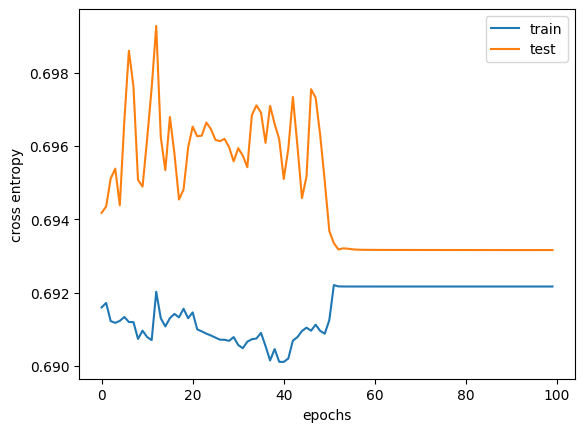

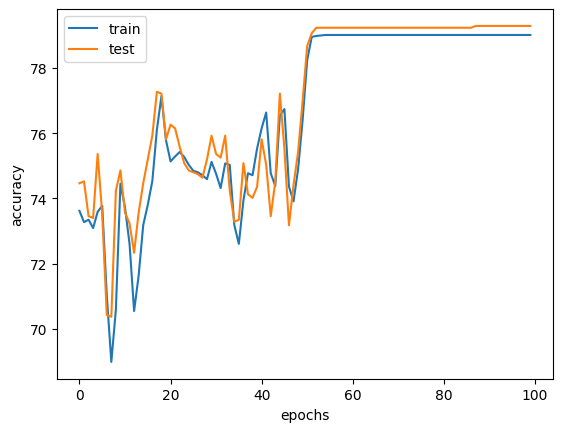

In [194]:
 
# Restore best model
adversary.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()